In [27]:
import pandas as pd # Pandas könyvtárak (adatbázis kezelése)
import numpy as np # NumPy könytárak (numerikus számítások)
import tensorflow as tf # Neurális hálók, mélytanulás
from sklearn.model_selection import train_test_split # Tanító és tesztelő részek
from sklearn.linear_model import LogisticRegression # Logisztikus regresszió bináris osztályozáshoz ()
from sklearn.preprocessing import StandardScaler # Standardizálás
from matplotlib import pyplot as plt # Diagramok és grafikonok

In [28]:
df = pd.read_csv('bmw_sales.csv') # Beolvasom a fájlt

In [29]:
df.head(2)

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low


In [31]:
df['Sales_Classification'].unique() # Ellenőrzöm egy oszlop tartalmát. A megjósolandó érték a Sales_Classification lesz.

array(['High', 'Low'], dtype=object)

In [32]:
df['Transmission'].unique() # Kiíratom, hogy egy oszlopban hányféle érték van.

array(['Manual', 'Automatic'], dtype=object)

In [33]:
df.head(1)

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High


In [35]:
columns = ['Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume']

for column in columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 -q1

    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
print(f"Új méret: {df.shape[0]} sor")

Új méret: 50000 sor


In [36]:
scaler = StandardScaler()
continuous_features=['Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume'] # Standardizálást elvégzem, , skálázom a numerikus értékeket
df[continuous_features]=scaler.fit_transform(df[continuous_features]) # fit kiszámolja az átlagot és a szórást, transzformálom az adatokat.

In [37]:
categorical_features=['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Engine_Size_L', 'Transmission'] # One-hot encoding: szétbontja a kategóriákat
df = pd.get_dummies(df, columns=categorical_features, # Fuel_Type: Petrol, Diesel, Hybrid, ELectric - 1 - ha igaz rá az adott típus
                    drop_first=True, dtype=int)

In [38]:
mapping = {'Low': 0, 'High': 1} # Numerikusan jelölöm a két kategóriatípust
df['Sales_Classification'] = df['Sales_Classification'].map(mapping)

In [39]:
print(df['Sales_Classification'].head()) # Kiíratom az első pár sort, és megjelenítem az értékeket

0    1
1    0
2    0
3    0
4    0
Name: Sales_Classification, dtype: int64


In [40]:
y = df['Sales_Classification'] # y: célváltozó, amit meg szeretnék jósoltatni
df = df.drop(columns=['Sales_Classification']) # Törlöm az adatbázisból
x = df # x: minden más elem

In [41]:
x_train, x_valtest, y_train, y_valtest = train_test_split( # 70-20-10 % felosztás tanító, validációs és tesztelő halmazra
    x, y, test_size=0.3, random_state=33
)

x_val, x_test, y_val, y_test = train_test_split(
    x_valtest, y_valtest, test_size=1/3, random_state=33
)

In [42]:
num_features = x_train.shape[1] #Tömb alakját lekérdezi és a második indexét megadja

In [43]:
from tensorflow.keras.models import Sequential # Rétegeket egymás után adom hozzá a neurális hálóhoz
from tensorflow.keras.layers import Dense # Rétegeket importálja
from tensorflow.keras.layers import LeakyReLU # Negatív kimenetekre is egy kis pozitív kimenetet ad
from tensorflow.keras.callbacks import EarlyStopping # Megelőzi a túltanulást, ha bizonyos időn belül nem javul a teljesítmény, leállítja a betanulást
from tensorflow.keras.layers import Dropout

In [44]:
model = Sequential() # Lehetővé teszi, hogy a neurális háló rétegeket egymásra lehessen építeni

In [45]:
model.add(Dense(64, activation="relu", input_shape=[num_features])) # Bemeneti méretet meghatározza 64 neuront tartalmaz + 1. rejtett réteg
model.add(Dropout(0.3))

model.add(Dense(32, activation="relu")) # 2. rejtett réteg, 
model.add(Dropout(0.2))

model.add(Dense(16, activation=LeakyReLU(alpha=0.1))) # 3. rejtett réteg
model.add(Dropout(0.2))

model.add(Dense(8, activation="relu"))
model.add(Dropout(0.1))

model.add(Dense(1, activation="sigmoid")) # Kimeneti réteg, binárisan osztályoz, hogy egy érték jelenjen meg.

c:\Users\jozsa\BEVADAT\beadando_1119\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\jozsa\BEVADAT\beadando_1119\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [46]:
model.compile( # Optimalizáló algoritmust beállítja az Adam algoritmussal
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # Tanulási ráta értékét megadjuk
    loss='binary_crossentropy', # Veszteségfüggvény bináris osztályozáshoz
    metrics=['accuracy'] # Pontosságot választjuk a metrikának
)

In [47]:
model.summary() # Összegezzük a modellt

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stopping = EarlyStopping(
    monitor='val_loss', # Validációs veszteség
    patience=4, # ha 4 epoch-on keresztül nem javul, a tanítás leáll
    restore_best_weights=True, # visszatölti a sűlyokat, amelyek a legjobb val. eredményt adják
    verbose=1 # kiírja a leállás okát
)

In [49]:
history = model.fit(
    x_train, y_train, # bemeneti rétegek
    epochs = 100, # 100-szor nézi át az adatokat
    batch_size=32, # 32 soronként frissíti a súlyokat
    validation_data=(x_val, y_val),# epoch-onként tesztel
    callbacks=[early_stopping],
    verbose = 1
)

Epoch 1/100


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9379 - loss: 0.1442 - val_accuracy: 0.9818 - val_loss: 0.0420
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9774 - loss: 0.0570 - val_accuracy: 0.9896 - val_loss: 0.0282
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9827 - loss: 0.0430 - val_accuracy: 0.9896 - val_loss: 0.0265
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9867 - loss: 0.0348 - val_accuracy: 0.9878 - val_loss: 0.0265
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9880 - loss: 0.0300 - val_accuracy: 0.9904 - val_loss: 0.0205
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9897 - loss: 0.0267 - val_accuracy: 0.9909 - val_loss: 0.0207
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9901 - loss: 0.0237 - val_accuracy: 0.9923 - val_loss: 0.0201
Epoch 8/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9918 - loss: 0.0205 - val_

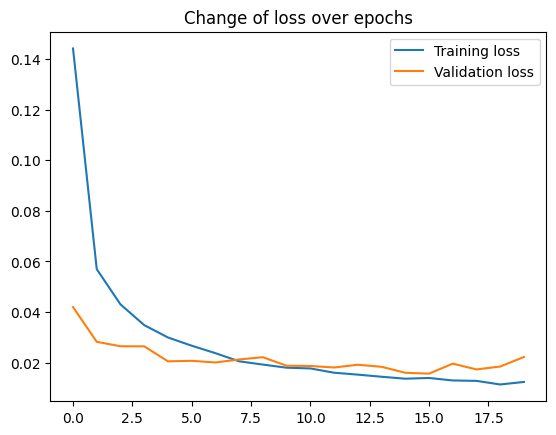

In [50]:
plt.plot(history.history['loss'], label="Training loss") # Tanítási és validációs veszteség megjelenítése
plt.plot(history.history['val_loss'], label="Validation loss") # Enyhe túltanulás jelentkezik
plt.legend()
plt.title('Change of loss over epochs')
plt.show()

In [51]:
y_pred_test=model.predict(x_test) # Kiszámítja az előrejelzett valószínűségeket mindegyik BMW-re az adathalmazban

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [52]:
y_pred_labels = np.where(y_pred_test >= 0.5, 1, 0) # A modell által kiszámított valószínűségi értékeket kerekíti 0 vagy 1 értékre

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix# Pontosság, AUC: ROC görbe alatti rész, két osztály között különbséget tesz
# ROC: True Positive Rate, False Positive Rate
# Konfúziós mátrix: hol téved a modell

In [54]:
accuracy_score(y_test, y_pred_labels)

0.9936

In [55]:
y_true = y_test # y_test értékeit átadja a true-nak

In [56]:
fpr, tpr, _ = roc_curve(y_true,y_pred_test) # fpr: az összes bemenet hány százalékán tévesztett a modell
# tpr: hány százalékban tippelt jól
# y_pred_test: modell által előrejelzett valószínűségi értékek

In [57]:
roc_auc = auc(fpr, tpr)# Összefoglaló a modell teljesítményéről

In [58]:
val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
print(f"Validation accuracy: {val_accuracy:.4f}")

Validation accuracy: 0.9938


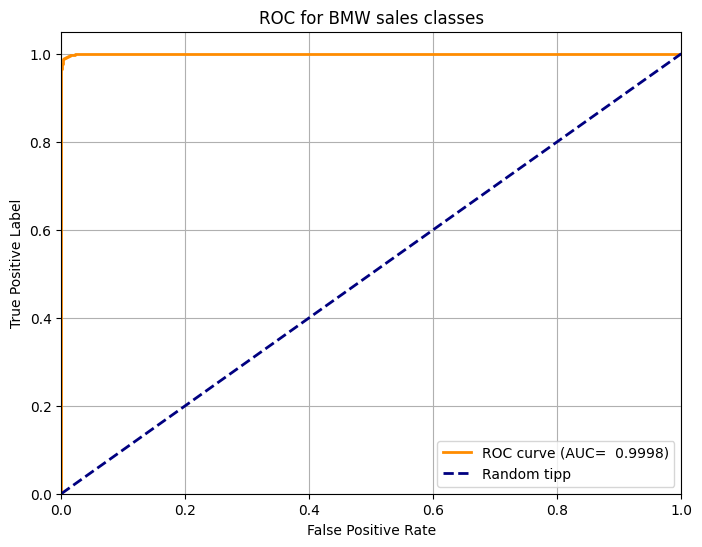

In [59]:
plt.figure(figsize=(8, 6))# Méret

plt.plot(fpr, tpr, color='darkorange', lw=2, # A görbét megrajzoló algoritmus
         label=f'ROC curve (AUC= {roc_auc: .4f})')

plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--', label='Random tipp') # Véletlenszerű tippelés

plt.xlim([0.0, 1.0]) # Tengelyhatárok
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Label')
plt.title('ROC for BMW sales classes')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

In [61]:
cm = confusion_matrix(y_test, y_pred_labels) # Konfúziós mátrix meghívása

In [62]:
cm_display=ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Low Sales (0)', 'High Sales (1)'])

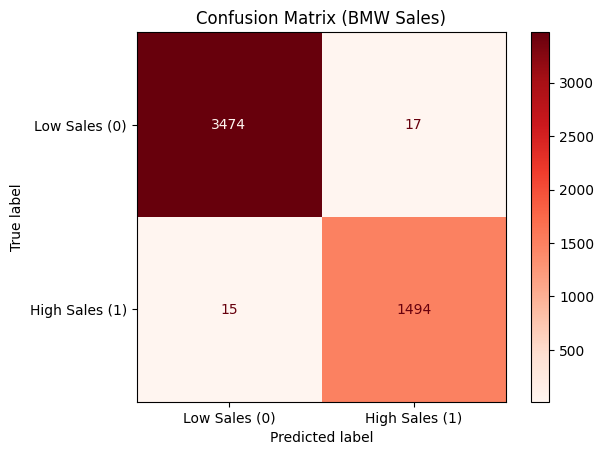

In [63]:
cm_display.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix (BMW Sales)')
plt.show()